In [2]:
import numpy as np
import pandas as pd
from scipy import stats

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

In [3]:
dowhy.__version__

'0.8'

In [4]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

In [1]:
# First, we'll build a structural causal model (SCM)
class GPSMemorySCM:
    
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_x = stats.truncnorm(0, np.infty, scale=5)
        self.u_y = stats.norm(scale=2)
        self.u_z = stats.norm(scale=2)
        self.u = stats.truncnorm(0, np.infty, scale=4)
        
    def sample(self, sample_size=100, treatment_value=None):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_x = self.u_x.rvs(sample_size)
        u_y = self.u_y.rvs(sample_size)
        u_z = self.u_z.rvs(sample_size)
        u = self.u.rvs(sample_size)
        
        if treatment_value:
            gps = np.array([treatment_value]*sample_size)
        else:
            gps = u_x + 0.7*u
            
        hippocampus = -0.6*gps + 0.25*u_z
        memory = 0.7*hippocampus + 0.25*u
        
        return gps, hippocampus, memory
    
    def intervene(self, treatment_value, sample_size=100):
        """Intervenes on the SCM"""
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)

In [16]:
# Instantiate the SCM
scm = GPSMemorySCM()

# Generate observational data
gps_obs, hippocampus_obs, memory_obs = scm.sample(1000)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([gps_obs, hippocampus_obs, memory_obs]).T, columns=['gps', 'hippocampus', 'memory'])

In [17]:
df.head()

,gps,hippocampus,memory
0,7.408786,-4.153955,-2.093157
1,7.041958,-4.491113,-1.620995
2,2.176230,-1.390302,-0.244418
3,1.552731,-0.622471,-0.385920
4,2.539961,-1.443536,-0.825174


# Step1. Moedling the problem

## Step1.1 Define the graph - `GML`

In [19]:
# Generate dictionary of varaibles
variables = {variable:col_name for col_name, variable in zip(df.columns,('X','Y','Z'))}
# Add unobserved variable
variables['U'] = 'memory'
variables

{'X': 'gps', 'Y': 'hippocampus', 'Z': 'memory', 'U': 'memory'}

In [22]:
# Generate list of varaibles include unobserved variabale
variables = list(df.columns)+['motivation']
variables

['gps', 'hippocampus', 'memory', 'motivation']

In [62]:
# Construct the graph
nodes = variables
edges = [
    ('gps','hippocampus'),
    ('hippocampus','memory'),
    ('motivation','gps'),
    ('motivation','memory')
]

# Generate the GML graph
gml_graph = 'graph [directed 1\n'

for node in nodes:
    gml_graph += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_graph += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'

gml_graph += ']'

In [56]:
print(gml_graph)

graph [directed 1
	node [id "gps" label "gps"]
	node [id "hippocampus" label "hippocampus"]
	node [id "memory" label "memory"]
	node [id "motivation" label "motivation"]
	edge [source "gps" target "hippocampus"]
	edge [source "hippocampus" target "memory"]
	edge [source "motivation" target "gps"]
	edge [source "motivation" target "gps"]
]


In [30]:
# Create the graph describing the causal structure
gml_graph = f"""
graph [
    directed 1
    
    node [id "X" label "X"]    
    node [id "Z" label "Z"]
    node [id "Y" label "Y"]
    node [id "U" label "U"]
    
    edge [source "X" target "Z"]
    edge [source "Z" target "Y"]
    edge [source "U" target "X"]
    edge [source "U" target "Y"]
]
"""

## Step1.2 Define the DoWhy model

In [63]:
# With graph
model = CausalModel (
    data=df,
    treatment='gps',
    outcome='memory',
    graph=gml_graph
)

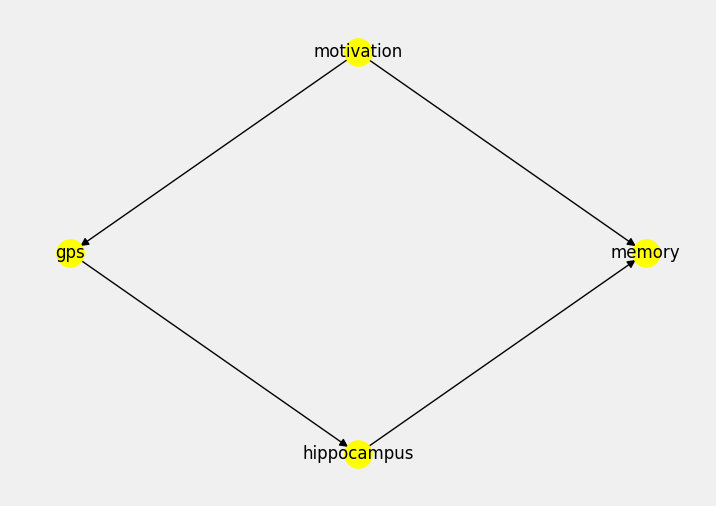

In [64]:
model.view_model()

# Step3. Estimate the causal effect

In [65]:
estimand = model.identify_effect()
print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡      d                  d                  ⎤
E⎢──────────────(memory)⋅──────([hippocampus])⎥
 ⎣d[hippocampus]         d[gps]               ⎦
Estimand assumption 1, Full-mediation: hippocampus intercepts (blocks) all directed paths from gps to m,e,m,o,r,y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{gps} and U→{hippocampus} then P(hippocampus|gps,U) = P(hippocampus|gps)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{hippocampus} and U→memory then P(memory|hippocampus, gps, U) = P(memory|hippocampus, gps)



In [66]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='frontdoor.two_stage_regression')

two_stage_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}


In [67]:
print(f'Estimate of causal effect (linear regression): {estimate.value}')

Estimate of causal effect (linear regression): -0.42084267978685125


## Step4. Run refutation tests

In [68]:
refute_subset = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name="data_subset_refuter", 
    subset_fraction=0.4)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, '

In [69]:
print(refute_subset)

Refute: Use a subset of data
Estimated effect:-0.42084267978685125
New effect:-0.41881322415399813
p value:0.96

